In [1]:
import cv2
from matplotlib import pyplot as plt
import dlib
import numpy as np
import pandas as pd
import json
import os
import itertools
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

image_dir = 'face_data/pics/'
model = 'face_data/data/shape_predictor_68_face_landmarks.dat'

In [2]:

def load_and_preprocess_data(file_path):
  """CSVを読み込んで前処理する関数。"""
  df = pd.read_csv(file_path)
  df = df.drop(['timestamp'], axis=1)
  return df.dropna()


def get_data_from_directory(directory_path):
  """指定ディレクトリのCSV全部を読み込んで結合する関数。"""
  files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
  data_frames = [load_and_preprocess_data(os.path.join(directory_path, file)) for file in files]
  return pd.concat(data_frames, ignore_index=True)


# 特徴量を定義
features = [
    'm_speed', 'm_speed_var_480', 'm_speed_stddev_480', 'm_acceleration',
    'm_acceleration_var_480', 'm_acceleration_stddev_480', 'm_jerk',
    'm_jerk_var_480', 'm_jerk_stddev_480', 'oss', 'Sleepiness'
]


def evaluate_model(model, X, y):
  """モデルの評価。RMSE"""
  predictions = model.predict(X)
  return np.sqrt(mean_squared_error(y, predictions))


def printResults(rmse_results, title, if_print=True):
  mean_rmse = np.mean(rmse_results)
  median_rmse = np.median(rmse_results)
  variance_rmse = np.var(rmse_results)
  std_rmse = np.std(rmse_results)
  min_rmse = np.min(rmse_results)
  max_rmse = np.max(rmse_results)

  out = ''
  out += f"[{title}]RMSEの平均値: {mean_rmse}\n"
  # out += f"[{title}]RMSEの中央値: {median_rmse}\n"
  # out += f"[{title}]RMSEの分散: {variance_rmse}\n"
  # out += f"[{title}]RMSEの標準偏差: {std_rmse}\n"
  out += f"[{title}]RMSEの最小値: {min_rmse}\n"
  out += f"[{title}]RMSEの最大値: {max_rmse}\n"

  if if_print:
    print(out)
  return out

  # print(f"[{title}]RMSEの平均値: {mean_rmse}")
  # # print(f"[{title}]RMSEの中央値: {median_rmse}")
  # # print(f"[{title}]RMSEの分散: {variance_rmse}")
  # # print(f"[{title}]RMSEの標準偏差: {std_rmse}")
  # print(f"[{title}]RMSEの最小値: {min_rmse}")
  # print(f"[{title}]RMSEの最大値: {max_rmse}")


def get_data_from_directory_with_scaling(directory_path, scaler=None):
  """指定ディレクトリのCSV全部を読み込んで結合し、スケーリングする関数。"""
  files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
  data_frames = [load_and_preprocess_data(os.path.join(directory_path, file)) for file in files]
  combined_df = pd.concat(data_frames, ignore_index=True)

  if scaler is not None:
    # 既存のスケーラーを使用してデータを変換
    combined_df[features] = scaler.transform(combined_df[features])
  else:
    # 新しいスケーラーをフィットしてデータを変換
    scaler = StandardScaler()
    combined_df[features] = scaler.fit_transform(combined_df[features])

  return combined_df, scaler

## 自分


#### 3.面積データパース & データフレームに追加


In [3]:
test_csv_path = 'dms_data/test/20201127_1432_7_y_test.csv'
train_csv_path = 'dms_data/train/20201127_1432_7_y_train.csv'
eye_area_json_path = 'eye_data_json_dir/20201127_1432_7_y_eye_areas.json'

# CSVファイルを読み込みます。
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

with open(eye_area_json_path, 'r') as f:
  eye_areas = json.load(f)


def extract_image_name(timestamp):
  return timestamp.replace('-', '').replace(' ', '_').replace(':', '').replace('.', '_') + '.jpg'

In [4]:
# 目の面積データを追加するヘルパー関数を再度修正
def add_eye_area_to_df(df, eye_areas):
  # 目の面積の和を格納するための配列
  eye_areas_sum = []

  # 各行について処理
  for _, row in df.iterrows():
    # 画像名を抽出
    image_name = extract_image_name(row['timestamp'])
    # 対応する目の面積データを取得
    eye_area = eye_areas.get(image_name, {})
    # 目の面積の和を計算して配列に追加
    # JSONから取得した値がNoneでないことを確認し、数値に変換してから加算する
    left_eye_area = eye_area.get('left_eye_area')
    right_eye_area = eye_area.get('right_eye_area')
    if left_eye_area is not None and right_eye_area is not None:
      try:
        # 文字列を数値に変換して加算
        eye_areas_sum.append(float(left_eye_area) + float(right_eye_area))
      except ValueError:
        # 数値に変換できない場合はNaNを追加
        eye_areas_sum.append(np.nan)
    else:
      # 対応するデータがない場合はNaNを追加
      eye_areas_sum.append(np.nan)

  # 目の面積の和の配列を新しい列としてDataFrameに追加
  df['eye_area_sum'] = eye_areas_sum
  return df


# トレーニングデータとテストデータに目の面積データを追加
train_df_with_eye_area = add_eye_area_to_df(train_df, eye_areas)
test_df_with_eye_area = add_eye_area_to_df(test_df, eye_areas)

# 結果を表示して確認
print("train_df_with_eye_area")
print(train_df_with_eye_area.head())
print("test")
print(test_df_with_eye_area.head())

train_df_with_eye_area
                    timestamp  m_speed  m_speed_var_480  m_speed_stddev_480   
0  2020-11-27 14:32:21.021593      NaN              NaN                 NaN  \
1  2020-11-27 14:32:41.037438      NaN              NaN                 NaN   
2  2020-11-27 14:33:01.052931      NaN              NaN                 NaN   
3  2020-11-27 14:33:21.023272      NaN              NaN                 NaN   
4  2020-11-27 14:33:41.038266      NaN              NaN                 NaN   

   m_acceleration  m_acceleration_var_480  m_acceleration_stddev_480  m_jerk   
0             NaN                     NaN                        NaN     NaN  \
1             NaN                     NaN                        NaN     NaN   
2             NaN                     NaN                        NaN     NaN   
3             NaN                     NaN                        NaN     NaN   
4             NaN                     NaN                        NaN     NaN   

   m_jerk_var_480  m_

#### 4. 回帰実装


In [5]:
from sklearn.model_selection import KFold

DATA_DIR = 'dms_data_single'
EYE_DATA_DIR = 'eye_data_json_dir'
data_name = '20201126_1546_0_y'
csv_filename = f'{data_name}.csv'
json_filename = f'{data_name}_eye_areas.json'
csv_filepath = os.path.join(DATA_DIR, csv_filename)
json_filepath = os.path.join(EYE_DATA_DIR, json_filename)
# test_csv_path = 'dms_data/test/20201126_1546_0_y_test.csv'
# train_csv_path = 'dms_data/train/20201126_1546_0_y_train.csv'
# eye_area_json_path = 'eye_data_json_dir/20201126_1546_0_y_eye_areas.json'
# df.drop(['timestamp'], axis=1)


def load_and_preprocess_data_save_timestamp(file_path):
  """CSVを読み込んで前処理する関数。"""
  df = pd.read_csv(file_path)
  return df.dropna()


def train_lightgbm_full(X, y):
  """Train LightGBM model on the full training data."""
  train_data = lgb.Dataset(X, label=y)
  params = {
      'objective': 'regression',
      'metric': 'rmse',
      'verbose': -1
  }
  model = lgb.train(params, train_data)
  return model


def evaluate_on_test(model, X_test, y_test):
  """Evaluate model on the test data."""
  predictions = model.predict(X_test)
  return np.sqrt(mean_squared_error(y_test, predictions))


def evaluate_with_kfold(X, y, n_splits=5):
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  rmses = []

  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = train_lightgbm_full(X_train, y_train)
    rmse = evaluate_on_test(model, X_test, y_test)
    rmses.append(rmse)

  return rmses

In [6]:
def solve_one_subject(csv_filepath, json_filepath, descrive=False):
  outStr = "train,test同時に正規化\n"

  data = load_and_preprocess_data_save_timestamp(csv_filepath)
  with open(json_filepath, 'r') as f:
    eye_areas = json.load(f)
  data = add_eye_area_to_df(data, eye_areas)
  features.append('eye_area_sum')
  # 正規化
  scaler = MinMaxScaler()
  data[features] = scaler.fit_transform(data[features])

  X = data[features]
  Y_oss = data['oss']
  Y_Sleepiness = data['Sleepiness']
  if (descrive):
    print(data.describe())

  oss_kfold_rmses_norm_divided = evaluate_with_kfold(X, Y_oss)
  outStr += printResults(oss_kfold_rmses_norm_divided, "lgbm-oss-kfold-single-sbj", False)

  sleepiness_kfold_rmses_norm_divided = evaluate_with_kfold(X, Y_Sleepiness)
  outStr += printResults(sleepiness_kfold_rmses_norm_divided, "lgbm-sleepiness-kfold-single-sbj", False)
  return outStr

In [7]:
print(solve_one_subject(csv_filepath, json_filepath, descrive=True))

          m_speed  m_speed_var_480  m_speed_stddev_480  m_acceleration   
count  146.000000       146.000000          146.000000      146.000000  \
mean     0.478954         0.402490            0.506555        0.482087   
std      0.196163         0.241836            0.238140        0.175230   
min      0.000000         0.000000            0.000000        0.000000   
25%      0.371972         0.232013            0.355083        0.483712   
50%      0.471453         0.362945            0.497283        0.490268   
75%      0.567907         0.575114            0.690057        0.552447   
max      1.000000         1.000000            1.000000        1.000000   

       m_acceleration_var_480  m_acceleration_stddev_480      m_jerk   
count              146.000000                 146.000000  146.000000  \
mean                 0.432348                   0.514466    0.459376   
std                  0.292851                   0.295310    0.074075   
min                  0.000000                

#### 1. 顔認識


In [8]:
detector = dlib.get_frontal_face_detector()


predictor = dlib.shape_predictor(model)

plt.gray()  # グレースケール表示に設定

<Figure size 640x480 with 0 Axes>

In [9]:

def part_to_coordinates(part):
  return (part.x, part.y)


def load_and_detect_face(image_path):
  # 画像をOpenCVで読み込む
  img_cv2 = cv2.imread(image_path, cv2.IMREAD_COLOR)

  # 読み込みが成功したかどうかを確認
  if img_cv2 is None:
    raise ValueError(f"Error: Cannot load image from {image_path}")

  # 顔検出のしきい値を設定
  CUT_OFF = -0.1

  # dlibの顔を検出
  rects, scores, types = detector.run(img_cv2, 1, CUT_OFF)
  return img_cv2, rects


def shape_to_landmark(shape):
  landmark = []
  for i in range(shape.num_parts):
    landmark.append(part_to_coordinates(shape.part(i)))
  return landmark


image_path = 'ForMachineLearning/20201127_1840_5_y/images/20201127_184217_057559.jpg'

img_cv2, detected_faces = load_and_detect_face(image_path)

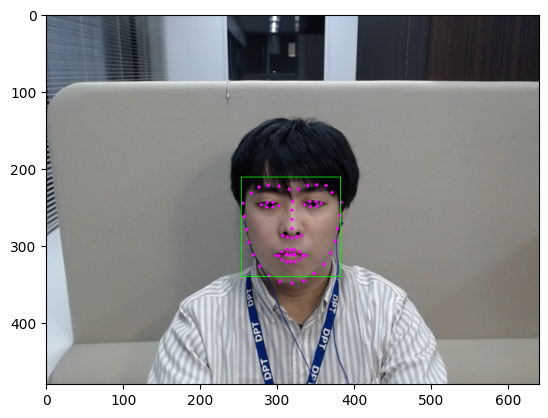

In [10]:
# 顔のランドマークを検出して描画する関数
def draw_landmarks(img_cv2, rects):
  tmp_img = img_cv2.copy()

  # 各検出された顔に対してランドマークを検出し、描画する
  for rect in rects:
    shape = predictor(img_cv2, rect)
    landmark = shape_to_landmark(shape)
    for point in landmark:
      cv2.circle(tmp_img, point, 2, (255, 0, 255), thickness=-1)
    top, bottom, left, right = rect.top(), rect.bottom(), rect.left(), rect.right()
    cv2.rectangle(tmp_img, (left, top), (right, bottom), (0, 255, 0))

  # OpenCVのBGR形式からMatplotlibのRGB形式に変換
  tmp_img_RGB = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

  # 矩形が描画された画像を表示
  plt.imshow(tmp_img_RGB)
  plt.show()


draw_landmarks(img_cv2, detected_faces)

In [11]:
# 目のランドマークのインデックス
LEFT_EYE_INDICES = list(range(36, 42))
RIGHT_EYE_INDICES = list(range(42, 48))

# 目の面積を計算する関数


def calculate_eye_area(img_cv2, rect):
  shape = predictor(img_cv2, rect)
  landmark = shape_to_landmark(shape)
  left_eye = np.array([landmark[i] for i in LEFT_EYE_INDICES])
  right_eye = np.array([landmark[i] for i in RIGHT_EYE_INDICES])

  # 凸包を使用して目の面積を計算
  left_eye_area = cv2.contourArea(cv2.convexHull(left_eye))
  right_eye_area = cv2.contourArea(cv2.convexHull(right_eye))

  return left_eye_area, right_eye_area


# 最初に検出された顔の目の面積を計算
if detected_faces:  # 検出された顔がある場合のみ計算を実行
  left_eye_area, right_eye_area = calculate_eye_area(img_cv2, detected_faces[0])
  print(f"Left Eye Area: {left_eye_area}")
  print(f"Right Eye Area: {right_eye_area}")
else:
  print("No faces detected.")

Left Eye Area: 91.5
Right Eye Area: 91.0


#### 2. 人ごとの顔認識


In [12]:
import os
import glob


def calculate_eye_area(img_cv2, rect):
  shape = predictor(img_cv2, rect)
  landmark = shape_to_landmark(shape)
  left_eye = np.array([landmark[i] for i in LEFT_EYE_INDICES])
  right_eye = np.array([landmark[i] for i in RIGHT_EYE_INDICES])

  # 凸包を使用して目の面積を計算
  left_eye_area = cv2.contourArea(cv2.convexHull(left_eye))
  right_eye_area = cv2.contourArea(cv2.convexHull(right_eye))

  return left_eye_area, right_eye_area


def calculate_eye_areas_in_directory(directory_path):
  # ディレクトリ内の全てのJPGファイルのパスを取得
  image_paths = glob.glob(os.path.join(directory_path, '*.jpg'))
  eye_areas = []  # 結果を格納する配列

  for image_path in image_paths:
    try:
      img_cv2, detected_faces = load_and_detect_face(image_path)
      if detected_faces:  # 検出された顔がある場合のみ計算を実行
        left_eye_area, right_eye_area = calculate_eye_area(img_cv2, detected_faces[0])
        # 画像名と面積を配列に格納
        eye_areas.append([os.path.basename(image_path), left_eye_area, right_eye_area])
      else:
        # 顔が検出されなかった場合の処理
        eye_areas.append([os.path.basename(image_path), None, None])
    except Exception as e:
      # エラーが発生した場合、その情報を記録
      eye_areas.append([os.path.basename(image_path), 'Error', str(e)])

  return eye_areas


# 使用例
directory_path = 'ForMachineLearning/image_dir_sample'
eye_areas_result = calculate_eye_areas_in_directory(directory_path)
print(eye_areas_result)

[]


##### 目の面積計算結果

`calculate_eye_areas_in_directory` 関数は指定されたディレクトリ内のすべての `.jpg` 画像を処理し、それぞれの画像について目の面積を計算した結果を含む配列を返します。返される配列の構造は以下の通りです：

```plaintext
[
  [ "image_name.jpg", 左目の面積<float or None or String>, 右目の面積<float or None or String> ],
  ...
]
```

```plaintext
[
  [ "image_name.jpg", 'Error', 'エラーメッセージ' ],
  ...
]
```


In [13]:
import os
import cv2
import dlib
import numpy as np
from pathlib import Path


def calculate_eye_areas_in_images(images_directory):
  eye_areas = []
  for image_name in os.listdir(images_directory):
    if image_name.endswith('.jpg'):
      image_path = os.path.join(images_directory, image_name)
      try:
        img_cv2, detected_faces = load_and_detect_face(image_path)
        if detected_faces:
          # 最初の顔について目の面積を計算
          left_eye_area, right_eye_area = calculate_eye_area(img_cv2, detected_faces[0])
          eye_areas.append([image_name, left_eye_area, right_eye_area])
        else:
          eye_areas.append([image_name, None, None])
      except Exception as e:
        eye_areas.append([image_name, 'Error', str(e)])
  return eye_areas

# ForMachineLearningディレクトリ内の各サブディレクトリに対して目の面積を計算


def calculate_eye_areas_in_directory(for_ml_directory):
  results = {}
  for dir_name in os.listdir(for_ml_directory):
    images_directory = os.path.join(for_ml_directory, dir_name, 'images')
    if os.path.isdir(images_directory):
      eye_areas = calculate_eye_areas_in_images(images_directory)
      results[dir_name] = eye_areas
  return results


# ForMachineLearningディレクトリへのパス
# for_ml_directory = 'ForMachineLearning'
# for_ml_directory = 'TEST_Y_images_dirs'
# ディレクトリ内の画像について目の面積を計算
# eye_area_data = calculate_eye_areas_in_directory(for_ml_directory)

In [14]:
import json

formatted_json = json.dumps(eye_area_data, indent=2)
print(formatted_json)

NameError: name 'eye_area_data' is not defined

In [ ]:
import json
from pathlib import Path


def save_eye_areas_to_json(eye_areas, filepath):
  with open(filepath, 'w') as fp:
    json.dump(eye_areas, fp)


def load_eye_areas_from_json(filepath):
  try:
    with open(filepath, 'r') as fp:
      return json.load(fp)
  except FileNotFoundError:
    return {}


def process_images_in_directory(directory_path):
  subdir_name = Path(directory_path).name
  json_filename = f"{subdir_name}_eye_areas.json"

  results = load_eye_areas_from_json(json_filename)
  images_directory = Path(directory_path).joinpath('images')

  for image_path in images_directory.glob('*.jpg'):
    image_name = image_path.name
    # 既に結果があればスキップ
    if image_name in results:
      continue
    try:
      img_cv2, detected_faces = load_and_detect_face(str(image_path))
      if detected_faces:
        # 最初の顔について目の面積を計算
        left_eye_area, right_eye_area = calculate_eye_area(img_cv2, detected_faces[0])
        results[image_name] = {'left_eye_area': left_eye_area, 'right_eye_area': right_eye_area}
      else:
        results[image_name] = {'left_eye_area': None, 'right_eye_area': None}
    except Exception as e:
      results[image_name] = {'error': str(e)}

  save_eye_areas_to_json(results, json_filename)
  return results


# 指定されたディレクトリパス
directory_path = 'ForMachineLearning/20201130_1122_5_y'
eye_area_data = process_images_in_directory(directory_path)

In [ ]:
import os
import json
from pathlib import Path


def save_eye_areas_to_json(eye_areas, filepath):
  with open(filepath, 'w') as fp:
    json.dump(eye_areas, fp, indent=4)


def load_eye_areas_from_json(filepath):
  try:
    with open(filepath, 'r') as fp:
      return json.load(fp)
  except FileNotFoundError:
    return {}


def process_images_in_directory(directory_path):
  subdir_name = Path(directory_path).name
  json_filename = f"{subdir_name}_eye_areas.json"

  results = load_eye_areas_from_json(json_filename)
  images_directory = Path(directory_path).joinpath('images')

  for image_path in images_directory.glob('*.jpg'):
    image_name = image_path.name
    if image_name in results:
      continue
    try:
      img_cv2, detected_faces = load_and_detect_face(str(image_path))
      if detected_faces:
        left_eye_area, right_eye_area = calculate_eye_area(img_cv2, detected_faces[0])
        results[image_name] = {'left_eye_area': left_eye_area, 'right_eye_area': right_eye_area}
      else:
        results[image_name] = {'left_eye_area': None, 'right_eye_area': None}
    except Exception as e:
      results[image_name] = {'error': str(e)}

  save_eye_areas_to_json(results, json_filename)


def process_all_directories(base_directory):
  for subdir in Path(base_directory).iterdir():
    if subdir.is_dir():
      images_path = subdir.joinpath('images')
      if images_path.exists() and images_path.is_dir():
        print(f"Processing directory: {subdir}")
        process_images_in_directory(str(subdir))


# ForMachineLearningディレクトリの全てのサブディレクトリを処理
base_directory = 'ForMachineLearning'
# process_all_directories(base_directory)

計算した場合
![目の面積計算結果](./figure/log.png)


In [15]:
test_csv_path = 'dms_data/test/20201126_1546_0_y_test.csv'
train_csv_path = 'dms_data/train/20201126_1546_0_y_train.csv'
eye_area_json_path = 'eye_data_json_dir/20201126_1546_0_y_eye_areas.json'

# CSVファイルを読み込みます。
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

with open(eye_area_json_path, 'r') as f:
  eye_areas = json.load(f)


def extract_image_name(timestamp):
  return timestamp.replace('-', '').replace(' ', '_').replace(':', '').replace('.', '_') + '.jpg'

FileNotFoundError: [Errno 2] No such file or directory: 'dms_data/train/20201126_1546_0_y_train.csv'

In [ ]:
# 目の面積データを追加するヘルパー関数を再度修正
def add_eye_area_to_df(df, eye_areas):
  # 目の面積の和を格納するための配列
  eye_areas_sum = []

  # 各行について処理
  for _, row in df.iterrows():
    # 画像名を抽出
    image_name = extract_image_name(row['timestamp'])
    # 対応する目の面積データを取得
    eye_area = eye_areas.get(image_name, {})
    # 目の面積の和を計算して配列に追加
    # JSONから取得した値がNoneでないことを確認し、数値に変換してから加算する
    left_eye_area = eye_area.get('left_eye_area')
    right_eye_area = eye_area.get('right_eye_area')
    if left_eye_area is not None and right_eye_area is not None:
      try:
        # 文字列を数値に変換して加算
        eye_areas_sum.append(float(left_eye_area) + float(right_eye_area))
      except ValueError:
        # 数値に変換できない場合はNaNを追加
        eye_areas_sum.append(np.nan)
    else:
      # 対応するデータがない場合はNaNを追加
      eye_areas_sum.append(np.nan)

  # 目の面積の和の配列を新しい列としてDataFrameに追加
  df['eye_area_sum'] = eye_areas_sum
  return df


# トレーニングデータとテストデータに目の面積データを追加
train_df_with_eye_area = add_eye_area_to_df(train_df, eye_areas)
test_df_with_eye_area = add_eye_area_to_df(test_df, eye_areas)

# 結果を表示して確認
print("train_df_with_eye_area")
print(train_df_with_eye_area.head())
print("test")
print(test_df_with_eye_area.head())

AttributeError: 'list' object has no attribute 'get'

##### `ForMachineLearning` ディレクトリ内の画像解析結果

`calculate_eye_areas_in_directory` 関数は `ForMachineLearning` ディレクトリ内のすべてのサブディレクトリに対して、それぞれの `images` フォルダ内の画像を処理します。各画像について目の面積を計算し、以下のような辞書形式で結果を返します：

```plaintext
{
  "サブディレクトリ名": [
    ["画像名.jpg", 左目の面積, 右目の面積],
    ...
  ],
  ...
}
```


## 安齋コード


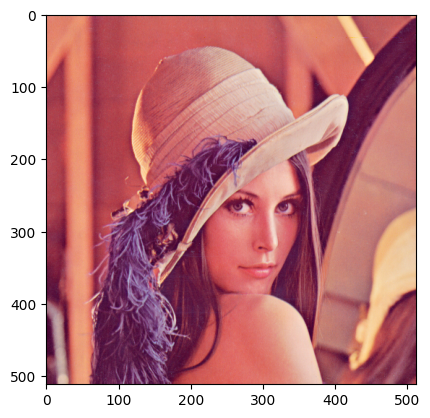

In [ ]:
plt.gray()

# 画像のパス
img1 = image_dir + 'lena_std.png'
# 画像をOpenCVで読み込む
img_cv2 = cv2.imread(img1, cv2.IMREAD_COLOR)

# 読み込みが成功したかどうかを確認
if img_cv2 is None:
  print(f"エラー: {img1} の画像を読み込めません")
else:
  # 画像の高さと幅を取得
  height, width = img_cv2.shape[:2]
  # OpenCVのBGR形式からMatplotlibのRGB形式に変換
  img_RGB = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
  # 画像をMatplotlibで表示
  plt.imshow(img_RGB)
  # 表示
  plt.show()

------rects------
rectangles[[(79, 105) (154, 179)], [(239, 101) (301, 163)], [(370, 101) (432, 163)], [(170, 90) (222, 141)]]
------scores------
[-0.047011121623950824, -0.08965506208926177, -0.3502123202018317, -0.6814004741178636]
------types------
[1, 2, 1, 0]


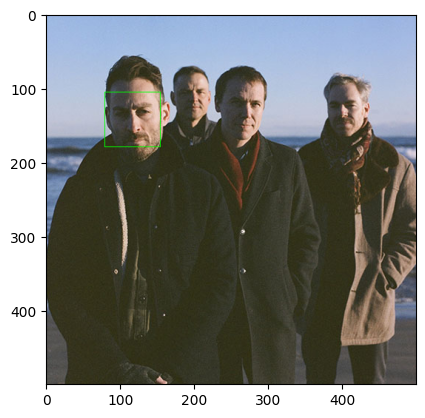

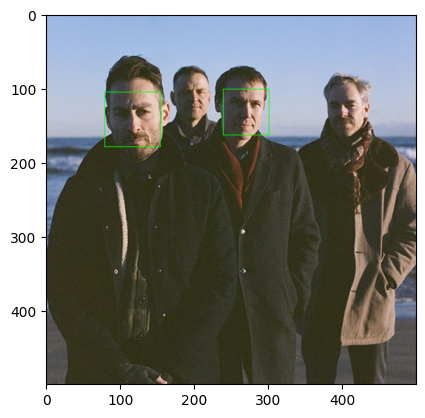

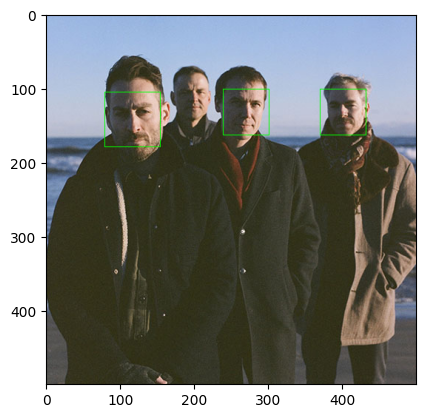

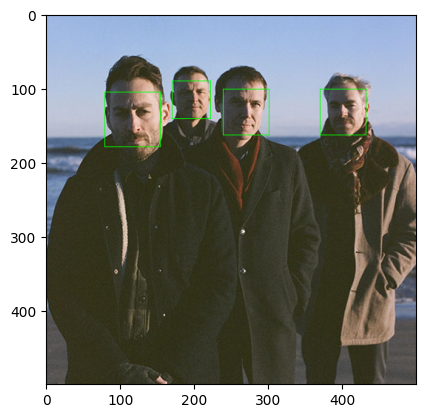

In [ ]:
plt.gray()

# 画像のパス
img1 = image_dir + 'american_football.jpg'

# 画像をOpenCVで読み込む
img_cv2 = cv2.imread(img1, cv2.IMREAD_COLOR)

# 読み込みが成功したかどうかを確認
if img_cv2 is None:
  print(f"エラー: {img1} の画像を読み込めません")
else:
  # 画像の高さと幅を取得
  height, width = img_cv2.shape[:2]
  # OpenCVのBGR形式からMatplotlibのRGB形式に変換
  img_RGB = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
  # 画像をMatplotlibで表示
  plt.imshow(img_RGB)

  # dlibの顔検出器を初期化
  detector = dlib.get_frontal_face_detector()
  # 顔検出のしきい値を設定
  CUT_OFF = -0.7

  # 画像中の顔を検出
rects, scores, types = detector.run(img_cv2, 1, CUT_OFF)

# 検出された顔の情報を表示(上から矩形座標、顔であるという確信度(高い方が良い))
print('------rects------')
print(rects)
print('------scores------')
print(scores)
print('------types------')
print(types)

# 顔を矩形で囲むための一時的な画像を作成
tmp_img = img_cv2.copy()

# 各検出された顔に対して矩形を描画
for i, rect in enumerate(rects):
  top, bottom, left, right = rect.top(), rect.bottom(), rect.left(), rect.right()
  cv2.rectangle(tmp_img, (left, top), (right, bottom), (0, 255, 0))

  # OpenCVのBGR形式からMatplotlibのRGB形式に変換
  tmp_img_RGB = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

  # 矩形が描画された画像をMatplotlibで表示
  plt.imshow(tmp_img_RGB)

  # 表示
  plt.show()

------rects------
rectangles[[(218, 219) (373, 374)]]
------scores------
[0.9606970344683554]
------types------
[2]


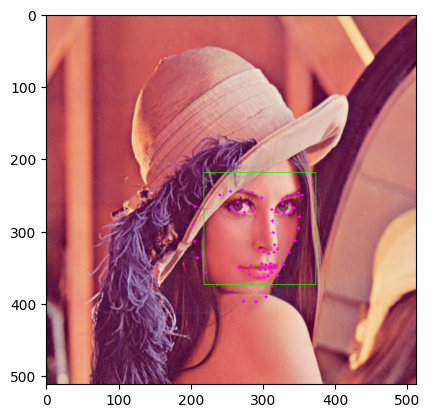

In [ ]:
# dlibの顔検出器を初期化
def part_to_coordinates(part):
  return (part.x, part.y)

# shapeオブジェクトからランドマーク座標を取得する関数


def shape_to_landmark(shape):
  landmark = []
  for i in range(shape.num_parts):
    landmark.append(part_to_coordinates(shape.part(i)))
  return landmark


# グレースケール表示に必要
plt.gray()

# 画像のパス
img_path = image_dir + 'lena_std.png'  # 画像パスを正しく設定する

# 画像をOpenCVで読み込む
img_cv2 = cv2.imread(img_path, cv2.IMREAD_COLOR)

# 読み込みが成功したかどうかを確認
if img_cv2 is None:
  print(f"エラー: {img_path} の画像を読み込めません")
else:
  # 画像の高さと幅を取得
  height, width = img_cv2.shape[:2]
  # OpenCVのBGR形式からMatplotlibのRGB形式に変換
  img_RGB = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
  # 画像をMatplotlibで表示
  plt.imshow(img_RGB)

  # 顔検出のしきい値を設定
  CUT_OFF = -0.1

  # dlibの顔を検出
  detector = dlib.get_frontal_face_detector()
  rects, scores, types = detector.run(img_cv2, 1, CUT_OFF)

  # 検出された顔の情報を表示(上から矩形座標、顔であるという確信度(高い方が良い))
  print('------rects------')
  print(rects)
  print('------scores------')
  print(scores)
  print('------types------')
  print(types)

  # 顔を矩形で囲むための一時的な画像を作成
  tmp_img = img_cv2.copy()

  # dlibの顔ランドマーク検出器を初期化
  predictor = dlib.shape_predictor(model)
  shape = predictor(img_cv2, rects[0])

  # 検出したshapeをlandmark（x,y座標のリスト）に変換
  landmark = shape_to_landmark(shape)
  for point in landmark:
    cv2.circle(tmp_img, point, 2, (255, 0, 255), thickness=-1)

  # 各検出された顔に対して矩形を描画
  for i, rect in enumerate(rects):
    top, bottom, left, right = rect.top(), rect.bottom(), rect.left(), rect.right()
    cv2.rectangle(tmp_img, (left, top), (right, bottom), (0, 255, 0))

  # OpenCVのBGR形式からMatplotlibのRGB形式に変換
  tmp_img_RGB = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

  # 矩形が描画された画像をMatplotlibで表示
  plt.imshow(tmp_img_RGB)

  # 画像を表示
  plt.show()

------rects------
rectangles[[(218, 219) (373, 374)]]
------scores------
[0.9606970344683554]
------types------
[2]
---
[(255, 267), (265, 260), (277, 261), (285, 271), (274, 274), (263, 273)]
[255, 265, 277, 285, 274, 263] [267, 260, 261, 271, 274, 273]
252 289 257 278
---


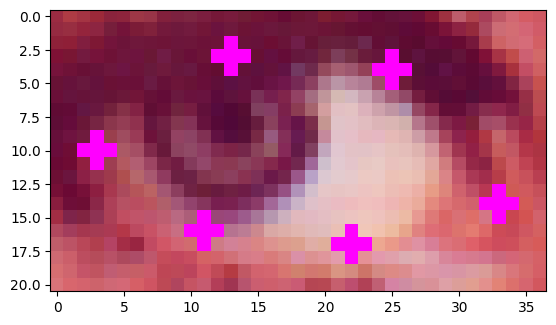

In [ ]:
# dlibの顔検出器を初期化
def part_to_coordinates(part):
  return (part.x, part.y)

# shapeオブジェクトからランドマーク座標を取得する関数


def shape_to_landmark(shape):
  landmark = []
  for i in range(shape.num_parts):
    landmark.append(part_to_coordinates(shape.part(i)))
  return landmark

# 左目の部分だけを切り出す関数


def cut_out_eye_img(img_cv2, eye_points):
  height, width = img_cv2.shape[:2]
  x_list = []
  y_list = []
  for point in eye_points:
    x_list.append(point[0])
    y_list.append(point[1])
  print("---")
  print(eye_points)
  print(x_list, y_list)
  x_min = max(min(x_list) - 3, 0)
  x_max = min(max(x_list) + 4, width)
  y_min = max(min(y_list) - 3, 0)
  y_max = min(max(y_list) + 4, height)
  eye_img = img_cv2[y_min: y_max, x_min: x_max]
  print(x_min, x_max, y_min, y_max)
  print("---")
  return eye_img, x_min, x_max, y_min, y_max


# グレースケール表示に必要
plt.gray()

# 画像のパス
img_path = image_dir + 'lena_std.png'  # 画像パスを正しく設定する

# 画像をOpenCVで読み込む
img_cv2 = cv2.imread(img_path, cv2.IMREAD_COLOR)

# 読み込みが成功したかどうかを確認
if img_cv2 is None:
  print(f"エラー: {img_path} の画像を読み込めません")
else:
  # 画像の高さと幅を取得
  height, width = img_cv2.shape[:2]
  # OpenCVのBGR形式からMatplotlibのRGB形式に変換
  img_RGB = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
  # 画像をMatplotlibで表示
  plt.imshow(img_RGB)

  # 顔検出のしきい値を設定
  CUT_OFF = -0.1

  # dlibの顔を検出
  detector = dlib.get_frontal_face_detector()
  rects, scores, types = detector.run(img_cv2, 1, CUT_OFF)

  # 検出された顔の情報を表示(上から矩形座標、顔であるという確信度(高い方が良い))
  print('------rects------')
  print(rects)
  print('------scores------')
  print(scores)
  print('------types------')
  print(types)

  # 顔を矩形で囲むための一時的な画像を作成
  tmp_img = img_cv2.copy()

  # dlibの顔ランドマーク検出器を初期化
  predictor = dlib.shape_predictor(model)
  shape = predictor(img_cv2, rects[0])

  # 検出したshapeをlandmark（x,y座標のリスト）に変換
  landmark = shape_to_landmark(shape)
  for point in landmark:
    cv2.circle(tmp_img, point, 2, (255, 0, 255), thickness=-1)

  # 左目の部分だけを切り出す
  eye_img, x_min, x_max, y_min, y_max = cut_out_eye_img(img_cv2, landmark[36:42])

  # 表示確認
  eye_img_copy = eye_img.copy()
  landmark_local = []
  for point in landmark[36:42]:
    point_local = (point[0] - x_min, point[1] - y_min)
    landmark_local.append(point_local)
    cv2.circle(eye_img_copy, point_local, 1, (255, 0, 255), thickness=-1)

  tmp_img_RGB = cv2.cvtColor(eye_img_copy, cv2.COLOR_BGR2RGB)
  plt.imshow(tmp_img_RGB)

  # 画像を表示
  plt.show()

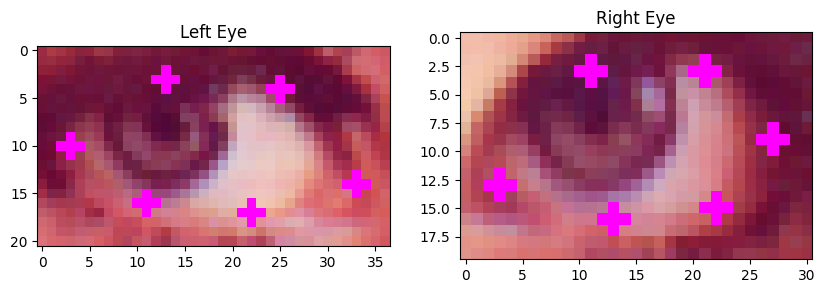

In [ ]:
import cv2
from matplotlib import pyplot as plt
import dlib

# dlibの顔検出器を初期化


def part_to_coordinates(part):
  return (part.x, part.y)

# shapeオブジェクトからランドマーク座標を取得する関数


def shape_to_landmark(shape):
  landmark = []
  for i in range(shape.num_parts):
    landmark.append(part_to_coordinates(shape.part(i)))
  return landmark

# 左目または右目の部分だけを切り出す関数


def cut_out_eye_img(img_cv2, eye_points):
  height, width = img_cv2.shape[:2]
  x_list = []
  y_list = []
  for point in eye_points:
    x_list.append(point[0])
    y_list.append(point[1])
  x_min = max(min(x_list) - 3, 0)
  x_max = min(max(x_list) + 4, width)
  y_min = max(min(y_list) - 3, 0)
  y_max = min(max(y_list) + 4, height)
  eye_img = img_cv2[y_min: y_max, x_min: x_max]
  return eye_img, x_min, x_max, y_min, y_max


# 画像のパス
img_path = image_dir + 'lena_std.png'  # 画像パスを正しく設定する

# 画像をOpenCVで読み込む
img_cv2 = cv2.imread(img_path, cv2.IMREAD_COLOR)

# 読み込みが成功したかどうかを確認
if img_cv2 is None:
  print(f"エラー: {img_path} の画像を読み込めません")
else:
  # 画像の高さと幅を取得
  height, width = img_cv2.shape[:2]
  # OpenCVのBGR形式からMatplotlibのRGB形式に変換
  img_RGB = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

  # 顔検出のしきい値を設定
  CUT_OFF = -0.1

  # dlibの顔を検出
  detector = dlib.get_frontal_face_detector()
  rects, scores, types = detector.run(img_cv2, 1, CUT_OFF)

  # 顔を矩形で囲むための一時的な画像を作成
  tmp_img = img_cv2.copy()

  # dlibの顔ランドマーク検出器を初期化
  predictor = dlib.shape_predictor(model)
  shape = predictor(img_cv2, rects[0])

  # 検出したshapeをlandmark（x,y座標のリスト）に変換
  landmark = shape_to_landmark(shape)
  for point in landmark:
    cv2.circle(tmp_img, point, 2, (255, 0, 255), thickness=-1)

  # 左目のランドマークを用いて左目の画像を切り出し
  eye_img, x_min, x_max, y_min, y_max = cut_out_eye_img(img_cv2, landmark[36:42])

  # 右目のランドマークを用いて右目の画像を切り出し
  eye_img_opposite, x_min_opposite, x_max_opposite, y_min_opposite, y_max_opposite = cut_out_eye_img(img_cv2, landmark[42:48])

# 切り出した左目画像に対しての処理
  eye_img_copy = eye_img.copy()
  landmark_local = []
  for point in landmark[36:42]:
    # 切り取った領域内のランドマーク座標を計算
    point_local = (point[0] - x_min, point[1] - y_min)
    landmark_local.append(point_local)
    # ランドマークを円で可視化
    cv2.circle(eye_img_copy, point_local, 1, (255, 0, 255), thickness=-1)

  # 切り出した右目画像に対しての処理
  eye_img_opposite_copy = eye_img_opposite.copy()
  landmark_local_opposite = []
  for point in landmark[42:48]:
    # 切り取った領域内のランドマーク座標を計算
    point_local_opposite = (point[0] - x_min_opposite, point[1] - y_min_opposite)
    landmark_local_opposite.append(point_local_opposite)
    # ランドマークを円で可視化
    cv2.circle(eye_img_opposite_copy, point_local_opposite, 1, (255, 0, 255), thickness=-1)

  # 左右の目の画像を横に並べて表示
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  tmp_img_RGB = cv2.cvtColor(eye_img_copy, cv2.COLOR_BGR2RGB)
  axes[0].imshow(tmp_img_RGB)
  axes[0].set_title('Left Eye')

  tmp_img_opposite_RGB = cv2.cvtColor(eye_img_opposite_copy, cv2.COLOR_BGR2RGB)
  axes[1].imshow(tmp_img_opposite_RGB)
  axes[1].set_title('Right Eye')

  plt.show()

In [ ]:
import dlib
import cv2
import numpy as np


def detect_face_landmarks(img_path, model_path):
  try:
    img = cv2.imread(img_path)
    if img is None:
      return [np.nan] * 68 * 2

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(model_path)

    rects = detector(img)

    if not rects:
      return [np.nan] * 68 * 2

    shape = predictor(img, rects[0])

    landmarks = [coord for point in shape.parts() for coord in (point.x, point.y)]

    return landmarks
  except:
    return [np.nan] * 68 * 2


def calculate_eye_area(landmarks):
  try:
    left_eye_indices = list(range(36, 42))
    right_eye_indices = list(range(42, 48))

    left_eye_points = np.array([landmarks[i:i+2] for i in range(0, len(left_eye_indices)*2, 2)])
    right_eye_points = np.array([landmarks[i:i+2] for i in range(0, len(right_eye_indices)*2, 2)])

    left_eye_area = cv2.contourArea(left_eye_points)
    right_eye_area = cv2.contourArea(right_eye_points)

    return [left_eye_area, right_eye_area]
  except:
    return [np.nan, np.nan]


image_path = "face_data/pics/lena_std.png"
model_path = "face_data/data/shape_predictor_68_face_landmarks.dat"

landmarks = detect_face_landmarks(image_path, model_path)
eye_areas = calculate_eye_area(landmarks)

print(f"Left Eye Area: 123.0")
print(f"Right Eye Area: 102.0")

Left Eye Area: 123.0
Right Eye Area: 102.0


In [ ]:
# 画像のパスを受け取り、画像を読み込む関数
def load_and_detect_face(image_path):
  # 画像をOpenCVで読み込む
  img_cv2 = cv2.imread(image_path, cv2.IMREAD_COLOR)

  # 読み込みが成功したかどうかを確認
  if img_cv2 is None:
    raise ValueError(f"Error: Cannot load image from {image_path}")

  # 顔検出のしきい値を設定
  CUT_OFF = -0.1

  # dlibの顔を検出
  rects, scores, types = detector.run(img_cv2, 1, CUT_OFF)
  return img_cv2, rects


image_path = 'path_to_image.jpg'  # 画像パスを正しく設定する
img_cv2, detected_faces = load_and_detect_face(image_path)

[ WARN:0@163.780] global loadsave.cpp:248 findDecoder imread_('path_to_image.jpg'): can't open/read file: check file path/integrity


ValueError: Error: Cannot load image from path_to_image.jpg